## Preprocessing-Accident
사고데이터들에 대한 좌표 변환 및 시계열 처리
결과물 : accidentdata.gpkg > geopandas read_file 로 불러 사용하면 됨

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [3]:
# 서울의 전체 행정동에 대한 Polygon/Grid
area = gpd.GeoDataFrame.from_file('/Users/dangchan/Desktop/Github/IOT_hackathon/data/LSMD_ADM_SECT_UMD_11.shp', encoding='cp949')
grid = gpd.GeoDataFrame.from_file('/Users/dangchan/Desktop/Github/IOT_hackathon/Seoul_Grid/grid.shp')

In [4]:
# 사고데이터 좌표변환 : From epsg:5181 to 5179
# 1) 좌표 분리
accident_df = pd.read_csv('/Users/dangchan/Desktop/Github/IOT_hackathon/TAAS/accident_df.csv')
acc_x, acc_y = [], []
for i in range(len(accident_df)):
    acc_x.append(float(accident_df.좌표[i].split(',')[0][1:]))
    acc_y.append(float(accident_df.좌표[i].split(',')[1][1:-1]))

accident_df['X'] = acc_x
accident_df['Y'] = acc_y
accident_df = accident_df[accident_df.columns.drop(['좌표', '좌표계', '사고번호', '시군구', '도로명주소'])] # 불필요한 열 제거

In [5]:
# 2) to GeoDataFrame
gdf_acc = gpd.GeoDataFrame(accident_df, geometry=gpd.points_from_xy(accident_df.X, accident_df.Y),crs='epsg:5181')
gdf_acc = gdf_acc.to_crs(epsg=5179)
gdf_acc.head(5)

,사고일시,요일,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,법규위반,노면상태,...,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,X,Y,geometry
0,2021년 1월 2일 10시,토요일,중상사고,0,1,0,0,차대차 - 측면충돌,안전운전불이행,-,...,남,28세,상해없음,이륜,남,49세,중상,194066.025793,449747.906695,POINT (949901.000 1949917.000)
1,2021년 1월 10일 16시,일요일,경상사고,0,0,1,0,차대차 - 측면충돌,불법유턴,-,...,남,24세,경상,승용,남,43세,상해없음,201601.913361,445614.349642,POINT (957412.000 1945745.000)
2,2021년 1월 14일 10시,목요일,부상신고사고,0,0,0,1,차대차 - 기타,안전운전불이행,-,...,여,24세,부상신고,승용,여,39세,상해없음,200524.559631,442588.445096,POINT (956319.000 1942726.000)
3,2021년 1월 15일 21시,금요일,경상사고,0,0,1,0,차대사람 - 보도통행중,안전운전불이행,-,...,남,26세,상해없음,보행자,여,30세,경상,209569.193218,445214.508960,POINT (965374.000 1945303.000)
4,2021년 1월 17일 18시,일요일,경상사고,0,0,1,0,차대사람 - 보도통행중,안전운전불이행,-,...,남,34세,상해없음,보행자,여,48세,경상,202131.535818,446477.501523,POINT (957946.000 1946605.000)


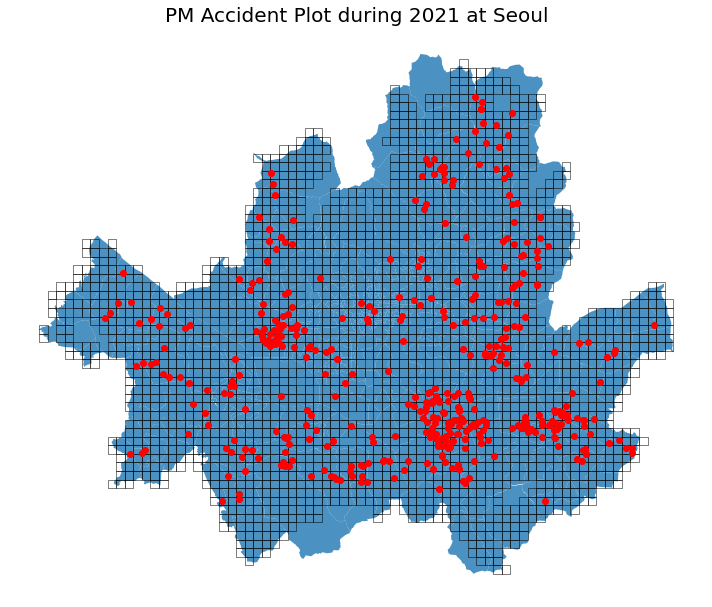

In [6]:
# 사고데이터 Visualize with Dots
fig, ax = plt.subplots(figsize = (10,10))
area.plot(ax=ax, zorder=1, alpha=0.8)
grid.plot(ax=ax,facecolor = 'none', alpha=0.5, zorder = 2) 
gdf_acc.geometry.plot(ax=ax, color='red', zorder=3) # high zorder > expressed at front layer
plt.axis('off')
plt.title("PM Accident Plot during 2021 at Seoul", fontsize=20)
plt.tight_layout()
plt.show()

In [7]:
# Grid/Accident 병합
grid['count'] = np.zeros(shape=len(grid))

for i in range(len(gdf_acc)):
    idx = np.where(grid.geometry.contains(gdf_acc.geometry[i]))[0][0]
    grid['count'][idx] += 1

grid.head(5)

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_9900/2088345026.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid['count'][idx] += 1


,FID,geometry,count
0,0,"POLYGON ((935035.249 1950165.520, 935035.249 1...",0.0
1,1,"POLYGON ((935035.249 1950665.520, 935035.249 1...",0.0
2,2,"POLYGON ((935535.249 1951665.520, 935535.249 1...",0.0
3,3,"POLYGON ((935535.249 1952165.520, 935535.249 1...",0.0
4,4,"POLYGON ((935535.249 1952665.520, 935535.249 1...",0.0


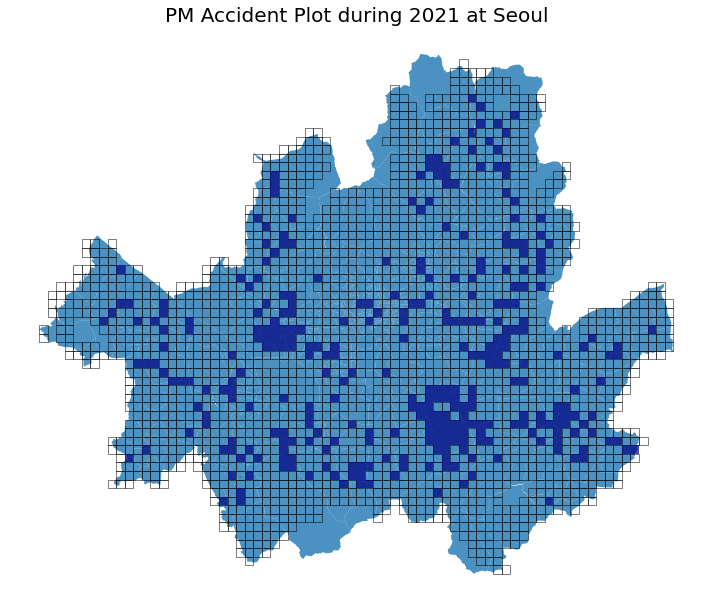

In [8]:
# 사고데이터 Visualize with Grid
fig, ax = plt.subplots(figsize = (10,10))
area.plot(ax=ax, zorder=1, alpha=0.8)
grid[grid['count']==0].plot(ax=ax,facecolor = 'none', alpha=0.5, zorder = 2)
grid[grid['count']>0].plot(ax=ax,facecolor = 'navy', alpha=0.7, zorder = 2)
plt.axis('off')
plt.title("PM Accident Plot during 2021 at Seoul", fontsize=20)
plt.tight_layout()
plt.show()

In [9]:
# time series treatment
from datetime import datetime

ls_dt = [] # date and time
ls_dow = [] # day of week(요일)
ls_hour = [] # hour

for i in range(len(gdf_acc)):
    dt_i = datetime.strptime(gdf_acc.사고일시[i], '%Y년 %m월 %d일 %H시')
    ls_dt.append(dt_i.strftime('%Y/%m/%d %H'))
    ls_dow.append(int(dt_i.weekday()))
    ls_hour.append(int(dt_i.strftime('%H')))

gdf_acc['datetime'] = ls_dt
gdf_acc['day'] = ls_dow
gdf_acc['hour'] = ls_hour

In [10]:
gdf_acc = gdf_acc[gdf_acc.columns.drop(['사고일시','요일'])]
gdf_acc.to_file('accidentdata.gpkg') # file saved
gdf_acc

,사고내용,사망자수,중상자수,경상자수,부상신고자수,사고유형,법규위반,노면상태,기상상태,도로형태,...,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,X,Y,geometry,datetime,day,hour
0,중상사고,0,1,0,0,차대차 - 측면충돌,안전운전불이행,-,맑음,단일로 - 기타,...,이륜,남,49세,중상,194066.025793,449747.906695,POINT (949901.000 1949917.000),2021/01/02 10,5,10
1,경상사고,0,0,1,0,차대차 - 측면충돌,불법유턴,-,맑음,교차로 - 교차로부근,...,승용,남,43세,상해없음,201601.913361,445614.349642,POINT (957412.000 1945745.000),2021/01/10 16,6,16
2,부상신고사고,0,0,0,1,차대차 - 기타,안전운전불이행,-,맑음,교차로 - 교차로부근,...,승용,여,39세,상해없음,200524.559631,442588.445096,POINT (956319.000 1942726.000),2021/01/14 10,3,10
3,경상사고,0,0,1,0,차대사람 - 보도통행중,안전운전불이행,-,맑음,단일로 - 기타,...,보행자,여,30세,경상,209569.193218,445214.508960,POINT (965374.000 1945303.000),2021/01/15 21,4,21
4,경상사고,0,0,1,0,차대사람 - 보도통행중,안전운전불이행,-,맑음,기타 - 기타,...,보행자,여,48세,경상,202131.535818,446477.501523,POINT (957946.000 1946605.000),2021/01/17 18,6,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,중상사고,0,1,0,0,차대차 - 기타,불법유턴,-,맑음,교차로 - 교차로횡단보도내,...,승합,남,59세,상해없음,197999.797759,452332.822470,POINT (953847.000 1952480.000),2021/12/28 22,1,22
441,부상신고사고,0,0,0,1,차대차 - 측면충돌,불법유턴,-,맑음,교차로 - 교차로안,...,승용,남,31세,상해없음,207293.731218,455099.358170,POINT (963152.000 1955196.000),2021/12/29 09,2,9
442,경상사고,0,0,1,0,차대차 - 기타,안전운전불이행,-,맑음,교차로 - 교차로횡단보도내,...,승용,남,44세,상해없음,204325.471836,446840.300297,POINT (960141.000 1946956.000),2021/12/29 09,2,9
443,중상사고,0,1,0,0,차대차 - 측면충돌,안전운전불이행,-,맑음,단일로 - 기타,...,승용,남,67세,상해없음,184868.764436,448577.573597,POINT (940701.000 1948796.000),2021/12/30 11,3,11
